# Mini-Lab: Logistic Regression and SVMs (Modeling)

__Team Members__
- Name 1: Jorge Olmos
- Name 2: Bosang Yun
- Name 3: Yucheol Shin
- Name 4: Siu Wai Yeung

In [5]:
import pandas as pd
import numpy as np

hotel_bookings = pd.read_csv('hotel_bookings.csv') # read in the csv file
hotel_bookings.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


# Data Importing and Cleaning

In [24]:
import math

hotel_bookings_transform = hotel_bookings
hotel_bookings_transform= hotel_bookings_transform.drop(columns=['agent','company', 'country'])

hotel_bookings_transform['meal']= hotel_bookings_transform['meal'].apply(lambda x: 'SC' if  x == 'Undefined'  else x)
hotel_bookings_transform['children']= hotel_bookings_transform['children'].apply(lambda x: 0 if  math.isnan(x)  else x)
hotel_bookings_transform['market_segment']= hotel_bookings_transform['market_segment'].apply(lambda x: 'Online TA' if  x == 'Undefined'  else x)
hotel_bookings_transform['distribution_channel']= hotel_bookings_transform['distribution_channel'].apply(lambda x: 'TA/TO' if  x == 'Undefined'  else x)


hotel_bookings_transform['hotel']=hotel_bookings_transform['hotel'].astype('category').cat.codes
hotel_bookings_transform['market_segment']=hotel_bookings_transform['market_segment'].astype('category').cat.codes
hotel_bookings_transform['meal']=hotel_bookings_transform['meal'].astype('category').cat.codes
hotel_bookings_transform['reservation_status']=hotel_bookings_transform['reservation_status'].astype('category').cat.codes
hotel_bookings_transform['distribution_channel']=hotel_bookings_transform['distribution_channel'].astype('category').cat.codes
hotel_bookings_transform['reserved_room_type']=hotel_bookings_transform['reserved_room_type'].astype('category').cat.codes
hotel_bookings_transform['assigned_room_type']=hotel_bookings_transform['assigned_room_type'].astype('category').cat.codes
hotel_bookings_transform['deposit_type']=hotel_bookings_transform['deposit_type'].astype('category').cat.codes
hotel_bookings_transform['customer_type']=hotel_bookings_transform['customer_type'].astype('category').cat.codes

assign_month = {"arrival_date_month": {"January": 1, "February": 2, "March": 3, "April": 4,"May": 5,"June": 6,"July": 7,"August": 8,"September": 9,"October": 10,"November": 11,"December": 12}}
hotel_bookings_transform = hotel_bookings_transform.replace(assign_month)

# Convert Date to Ordinal
import datetime as dt
hotel_bookings_transform['reservation_status_date'] = pd.to_datetime(hotel_bookings_transform['reservation_status_date'])
hotel_bookings_transform['reservation_status_date'] = hotel_bookings_transform['reservation_status_date'].map(dt.datetime.toordinal)

# Select modeling techniques

In [ ]:
## todo:

# Generate test design: 

## Normalization

- SVM tries to maximize the distance between the support vectors and the separating plane. 
- Prior to conducting SVM, we need to normalize the dataset so we can get rid of bias and dominance of certain features over others. 
- The result of applying normalized dataset will be having the same influence on the distance metric, thus boosting the accuracy of the model. 

In [25]:
X=hotel_bookings_transform.drop(columns=['is_canceled'])
y=hotel_bookings_transform.is_canceled

In [26]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X)
scaler

scaler.mean_
scaler.scale_

X_scaled = scaler.transform(X)

Verifying each feature has a mean of zero:

In [27]:
X_scaled.mean(axis=0)

array([-7.99873890e-17,  6.09427725e-17, -8.40629369e-14, -7.61784657e-18,
       -1.29503392e-16,  2.47580013e-17,  1.19743026e-16, -2.76146938e-17,
        3.23758479e-17, -3.99936945e-17,  2.04729627e-17, -2.28535397e-17,
        2.47580013e-17,  3.23758479e-17,  9.52230821e-18, -3.14236171e-17,
        2.04729627e-17, -3.38041941e-17,  6.95128499e-17,  3.42803096e-17,
        1.90446164e-18,  3.90414637e-17,  3.72322251e-16,  2.51388937e-16,
       -5.71338493e-18, -5.33249260e-17,  7.61784657e-17, -1.46902553e-13])

Verifying that the standard deviation should be 1:

In [28]:
X_scaled.std(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

## Feature Selection 

Running initial model to select best parameters to be used for RFE selection:

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=10, test_size=0.10, random_state=0)
regEstimator = LogisticRegression()

parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced','none']
              ,'random_state': [10]
              ,'solver': ['lbfgs']
              ,'max_iter':[500,1000]
             }


from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring='accuracy')

regGridSearch.fit(X_scaled, y)

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.7s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   55.4s
[Parallel(n_jobs=8)]: Done 280 out of 280 | elapsed:  2.9min finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
             estimator=LogisticRegression(), n_jobs=8,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'class_weight': ['balanced', 'none'],
                         'max_iter': [500, 1000], 'penalty': ['l2'],
                         'random_state': [10], 'solver': ['lbfgs']},
             scoring='accuracy', verbose=1)

### RFE Selection

In [41]:
from sklearn.feature_selection import RFECV

#Create a regression estimator with best parameters for cross validation
classifierEst = regGridSearch.best_estimator_

rfecv = RFECV(estimator=classifierEst, step=1, cv=cv, scoring='accuracy')
rfecv.fit(X_scaled, y)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

RFECV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
      estimator=LogisticRegression(C=1000, class_weight='balanced',
                                   max_iter=1000, random_state=10),
      scoring='accuracy')

Here we're examining the plot of the categorical values of interest and looking at the optimal number of features:

Optimal number of features : 12


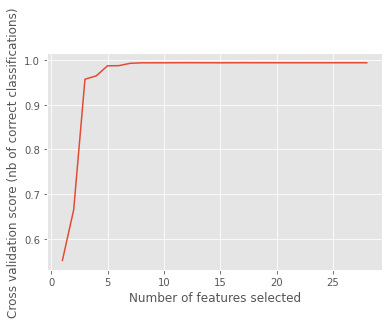

In [43]:
# Examine categorical variables of interest  
import matplotlib.pyplot as plt
%matplotlib inline

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [44]:
#Plot the RFE Rankings
plt.style.use('ggplot')

rfe_ft_imp_df = pd.DataFrame({'feature_names':X.columns, 'weights':rfecv.grid_scores_})
rfe_ft_imp_df.sort_values(by='weights', inplace=True, ascending=False )

top_features = rfe_ft_imp_df.head(50)

top_features

,feature_names,weights
11,meal,0.993701
16,previous_bookings_not_canceled,0.993685
18,assigned_room_type,0.993626
24,required_car_parking_spaces,0.993626
12,market_segment,0.993626
17,reserved_room_type,0.993609
26,reservation_status,0.993609
25,total_of_special_requests,0.993609
10,babies,0.993592
27,reservation_status_date,0.993592


## Cross Validation

In [61]:
from sklearn.model_selection import StratifiedShuffleSplit 
from sklearn.model_selection import train_test_split
from sklearn import metrics as mt

#cv = StratifiedShuffleSplit(n_splits=10,train_size=0.8,random_state=10)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,test_size=0.2,random_state=10)

# trainSet = []
# testSet = []

# for train, test in cv.split(X_scaled,y):
#     trainSet.append(train)
#     testSet.append(test)

[[-0.71061889  0.54264595 -0.2212864  ...  0.54066585  0.70352647
  -0.08732091]
 [ 1.40722407  1.82466544  1.19219514 ...  1.80202581 -1.30541936
   0.25293766]
 [-0.71061889 -0.9546031  -1.63476794 ... -0.72069411  0.70352647
  -1.2738636 ]
 ...
 [-0.71061889  0.20576491 -0.2212864  ...  0.54066585  0.70352647
   0.04354777]
 [-0.71061889 -0.76744697  1.19219514 ... -0.72069411  0.70352647
   0.85929587]
 [-0.71061889 -0.9546031  -0.2212864  ...  0.54066585  0.70352647
  -0.82018551]]


# Build model

To build our model, after analyzing our feature selection we decided to keep all features that had weights greater than .9

## Logistic Regression 

In [ ]:
X_sel = X_scaled[['hotel',
'arrival_date_year',
'arrival_date_month',
'arrival_date_week_number',
'lead_time',
'arrival_date_day_of_month',
'stays_in_weekend_nights',
'stays_in_week_nights',
'adults',
'children',
'babies',
'meal',
'previous_cancellations',
'previous_bookings_not_canceled',
'distribution_channel',
'is_repeated_guest',
'market_segment',
'reserved_room_type',
'assigned_room_type',
'booking_changes',
'deposit_type',
'customer_type',
'days_in_waiting_list',,
'adr']]

Doing f1 scoring, which is best for a binary target like is_canceled

In [ ]:
from sklearn.linear_model import LogisticRegression
regEstimator = LogisticRegression()


tuning_parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced', 'none']
              ,'random_state': [10]
              ,'solver': ['lbfgs']
              ,'max_iter':[100,500]
             }


#Doing f1 for accuracy best for binary

#Create a grid search object using the  

from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=tuning_parameters
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_scaled, y)

In [ ]:
 regGridSearch.best_params_

In [ ]:
regGridSearch.best_score_

In [ ]:
 t.best_estimator_.intercept_

In [ ]:
regGridSearch.best_estimator_.coef_

## Support Vector Machines

In [ ]:
from sklearn import svm


# X_sel = X_scaled[['hotel',
# 'arrival_date_year',
# 'arrival_date_month',
# 'arrival_date_week_number',
# 'lead_time',
# 'arrival_date_day_of_month',
# 'stays_in_weekend_nights',
# 'stays_in_week_nights',
# 'adults',
# 'children',
# 'babies',
# 'meal',
# 'previous_cancellations',
# 'previous_bookings_not_canceled',
# 'distribution_channel',
# 'is_repeated_guest',
# 'market_segment',
# 'reserved_room_type',
# 'assigned_room_type',
# 'booking_changes',
# 'deposit_type',
# 'customer_type',
# 'days_in_waiting_list',
# 'adr']]

svm_estimator = svm.SVC()

tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]


svmGridSearch = GridSearchCV(estimator=svm_estimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=tuned_parameters
                   , cv=cv # KFolds = 10
                   , scoring='accuracy')

svmGridSearch.fit(X_train, y_train)

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']


classification_report(y_true, y_pred))

# Assess model